In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm

In [6]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
])


val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [49]:
train_dir = os.path.join('/content/drive/MyDrive/natural-disaster-image-dataset/natural_disaster_dataset/train')
val_dir = os.path.join('/content/drive/MyDrive/natural-disaster-image-dataset/natural_disaster_dataset/validation')
test_dir = os.path.join('/content/drive/MyDrive/natural-disaster-image-dataset/natural_disaster_dataset/test')

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

print(train_dataset.class_to_idx)


{'cyclone': 0, 'earthquake': 1, 'flood': 2, 'wildfire': 3}


In [8]:

batch_size = 32

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size ,
                          shuffle=True,
                          num_workers=4,
                          pin_memory=True)

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=4)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=4)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


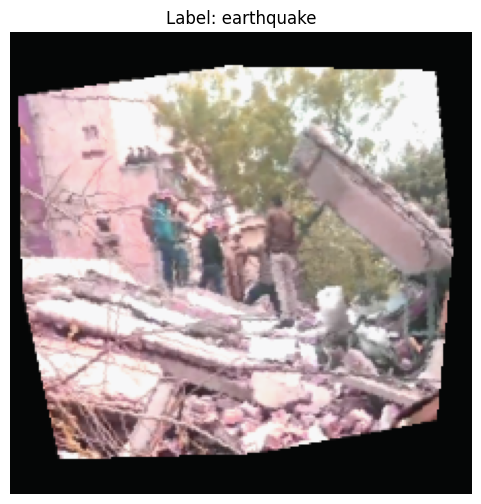

In [108]:


import matplotlib.pyplot as plt
import numpy as np
import random


index = random.randint(0, len(train_dataset) - 1)
image, label = train_dataset[index]


image = image.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = std * image + mean
image = np.clip(image, 0, 1)

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title(f"Label: {train_dataset.classes[label]}")
plt.axis('off')
plt.show()



In [22]:


model = nn.Sequential(
    nn.AdaptiveAvgPool2d((224, 224)),


    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(512, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 4)
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


summary(model, input_size=(3,224, 224))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
 AdaptiveAvgPool2d-1          [-1, 3, 224, 224]               0
            Conv2d-2         [-1, 64, 224, 224]           1,792
       BatchNorm2d-3         [-1, 64, 224, 224]             128
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
       BatchNorm2d-7        [-1, 128, 112, 112]             256
              ReLU-8        [-1, 128, 112, 112]               0
         MaxPool2d-9          [-1, 128, 56, 56]               0
           Conv2d-10          [-1, 256, 56, 56]         295,168
      BatchNorm2d-11          [-1, 256, 56, 56]             512
             ReLU-12          [-1, 256, 56, 56]               0
        MaxPool2d-13          [-1, 256, 28, 28]               0
           Conv2d-14          [-1, 512,

In [24]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [25]:
def train_model(model, criterion, optimizer, num_epochs=10):
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device).long()   # <-- önemli

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)  # <-- önemli

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

                preds = outputs.argmax(dim=1)        # <-- önemli
                running_corrects += torch.sum(preds == labels)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                torch.save(model.state_dict(), 'best_model.pth')

        print()

    print(f'Best val Acc: {best_val_accuracy:.4f}')

    torch.save(model.state_dict(), 'last_model.pth')

    return model


In [26]:
num_epochs = 10
trained_model = train_model(model, criterion, optimizer, num_epochs)

Epoch 1/10
----------


train: 100%|██████████| 104/104 [01:40<00:00,  1.04it/s]


train Loss: 3.5913 Acc: 0.4958


val: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


val Loss: 0.8820 Acc: 0.6892

Epoch 2/10
----------


train: 100%|██████████| 104/104 [01:35<00:00,  1.09it/s]


train Loss: 0.9633 Acc: 0.6791


val: 100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


val Loss: 1.1429 Acc: 0.6374

Epoch 3/10
----------


train: 100%|██████████| 104/104 [01:38<00:00,  1.05it/s]


train Loss: 0.6990 Acc: 0.7514


val: 100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


val Loss: 0.5829 Acc: 0.8108

Epoch 4/10
----------


train: 100%|██████████| 104/104 [01:34<00:00,  1.10it/s]


train Loss: 0.6199 Acc: 0.7703


val: 100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


val Loss: 0.6337 Acc: 0.7793

Epoch 5/10
----------


train: 100%|██████████| 104/104 [01:36<00:00,  1.07it/s]


train Loss: 0.5807 Acc: 0.7848


val: 100%|██████████| 14/14 [00:11<00:00,  1.20it/s]


val Loss: 0.7416 Acc: 0.7500

Epoch 6/10
----------


train: 100%|██████████| 104/104 [01:34<00:00,  1.10it/s]


train Loss: 0.5642 Acc: 0.7902


val: 100%|██████████| 14/14 [00:11<00:00,  1.20it/s]


val Loss: 0.7357 Acc: 0.7635

Epoch 7/10
----------


train: 100%|██████████| 104/104 [01:37<00:00,  1.07it/s]


train Loss: 0.5356 Acc: 0.8031


val: 100%|██████████| 14/14 [00:11<00:00,  1.20it/s]


val Loss: 0.6327 Acc: 0.8153

Epoch 8/10
----------


train: 100%|██████████| 104/104 [01:37<00:00,  1.07it/s]


train Loss: 0.5161 Acc: 0.8104


val: 100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


val Loss: 0.5660 Acc: 0.8063

Epoch 9/10
----------


train: 100%|██████████| 104/104 [01:33<00:00,  1.12it/s]


train Loss: 0.4746 Acc: 0.8209


val: 100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


val Loss: 0.6136 Acc: 0.8221

Epoch 10/10
----------


train: 100%|██████████| 104/104 [01:35<00:00,  1.09it/s]


train Loss: 0.4670 Acc: 0.8284


val: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


val Loss: 0.7657 Acc: 0.8108

Best val Acc: 0.8221


In [73]:
num_epochs = 10
trained_model = train_model(model, criterion, optimizer, num_epochs)

Epoch 1/10
----------


train:   0%|          | 0/104 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train: 100%|██████████| 104/104 [01:36<00:00,  1.08it/s]


train Loss: 0.5164 Acc: 0.8137


val: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


val Loss: 0.7912 Acc: 0.7365

Epoch 2/10
----------


train: 100%|██████████| 104/104 [01:35<00:00,  1.08it/s]


train Loss: 0.4644 Acc: 0.8374


val: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


val Loss: 0.6469 Acc: 0.7995

Epoch 3/10
----------


train: 100%|██████████| 104/104 [01:34<00:00,  1.10it/s]


train Loss: 0.4634 Acc: 0.8390


val: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


val Loss: 0.5392 Acc: 0.8198

Epoch 4/10
----------


train: 100%|██████████| 104/104 [01:33<00:00,  1.11it/s]


train Loss: 0.4396 Acc: 0.8501


val: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


val Loss: 0.6785 Acc: 0.7838

Epoch 5/10
----------


train: 100%|██████████| 104/104 [01:33<00:00,  1.11it/s]


train Loss: 0.4417 Acc: 0.8411


val: 100%|██████████| 14/14 [00:11<00:00,  1.19it/s]


val Loss: 0.5337 Acc: 0.8063

Epoch 6/10
----------


train: 100%|██████████| 104/104 [01:34<00:00,  1.10it/s]


train Loss: 0.4189 Acc: 0.8543


val: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


val Loss: 0.5675 Acc: 0.7883

Epoch 7/10
----------


train: 100%|██████████| 104/104 [01:34<00:00,  1.10it/s]


train Loss: 0.3950 Acc: 0.8624


val: 100%|██████████| 14/14 [00:11<00:00,  1.19it/s]


val Loss: 0.5719 Acc: 0.8221

Epoch 8/10
----------


train: 100%|██████████| 104/104 [01:33<00:00,  1.11it/s]


train Loss: 0.4050 Acc: 0.8615


val: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


val Loss: 0.7924 Acc: 0.7590

Epoch 9/10
----------


train: 100%|██████████| 104/104 [01:33<00:00,  1.11it/s]


train Loss: 0.3746 Acc: 0.8621


val: 100%|██████████| 14/14 [00:11<00:00,  1.22it/s]


val Loss: 0.4836 Acc: 0.8311

Epoch 10/10
----------


train: 100%|██████████| 104/104 [01:33<00:00,  1.11it/s]


train Loss: 0.3875 Acc: 0.8651


val: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


val Loss: 0.5457 Acc: 0.8041

Best val Acc: 0.8311


In [76]:
num_epochs = 10
trained_model = train_model(model, criterion, optimizer, num_epochs)

Epoch 1/10
----------


train:   0%|          | 0/104 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train: 100%|██████████| 104/104 [01:34<00:00,  1.10it/s]


train Loss: 0.3652 Acc: 0.8760


val: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


val Loss: 0.7504 Acc: 0.7973

Epoch 2/10
----------


train: 100%|██████████| 104/104 [01:37<00:00,  1.06it/s]


train Loss: 0.3625 Acc: 0.8724


val: 100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


val Loss: 0.5567 Acc: 0.7883

Epoch 3/10
----------


train: 100%|██████████| 104/104 [01:33<00:00,  1.11it/s]


train Loss: 0.3754 Acc: 0.8639


val: 100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


val Loss: 0.4516 Acc: 0.8559

Epoch 4/10
----------


train: 100%|██████████| 104/104 [01:34<00:00,  1.10it/s]


train Loss: 0.3635 Acc: 0.8778


val: 100%|██████████| 14/14 [00:10<00:00,  1.27it/s]


val Loss: 0.5044 Acc: 0.8266

Epoch 5/10
----------


train: 100%|██████████| 104/104 [01:31<00:00,  1.13it/s]


train Loss: 0.3308 Acc: 0.8865


val: 100%|██████████| 14/14 [00:11<00:00,  1.22it/s]


val Loss: 0.5306 Acc: 0.8176

Epoch 6/10
----------


train: 100%|██████████| 104/104 [01:33<00:00,  1.11it/s]


train Loss: 0.3458 Acc: 0.8874


val: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


val Loss: 0.4423 Acc: 0.8694

Epoch 7/10
----------


train: 100%|██████████| 104/104 [01:34<00:00,  1.10it/s]


train Loss: 0.3412 Acc: 0.8829


val: 100%|██████████| 14/14 [00:11<00:00,  1.22it/s]


val Loss: 0.5552 Acc: 0.8041

Epoch 8/10
----------


train: 100%|██████████| 104/104 [01:35<00:00,  1.09it/s]


train Loss: 0.3139 Acc: 0.8931


val: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


val Loss: 0.4677 Acc: 0.8604

Epoch 9/10
----------


train: 100%|██████████| 104/104 [01:32<00:00,  1.12it/s]


train Loss: 0.3247 Acc: 0.8892


val: 100%|██████████| 14/14 [00:11<00:00,  1.20it/s]


val Loss: 0.5222 Acc: 0.8401

Epoch 10/10
----------


train: 100%|██████████| 104/104 [01:33<00:00,  1.11it/s]


train Loss: 0.3243 Acc: 0.8907


val: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


val Loss: 0.5312 Acc: 0.8468

Best val Acc: 0.8694


In [109]:
num_epochs = 20
trained_model = train_model(model, criterion, optimizer, num_epochs)

Epoch 1/20
----------


train:   0%|          | 0/104 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
train: 100%|██████████| 104/104 [01:32<00:00,  1.13it/s]


train Loss: 0.2996 Acc: 0.8995


val: 100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


val Loss: 0.7553 Acc: 0.8131

Epoch 2/20
----------


train: 100%|██████████| 104/104 [01:32<00:00,  1.12it/s]


train Loss: 0.3136 Acc: 0.8886


val: 100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


val Loss: 0.6448 Acc: 0.8266

Epoch 3/20
----------


train: 100%|██████████| 104/104 [01:34<00:00,  1.10it/s]


train Loss: 0.2970 Acc: 0.8992


val: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


val Loss: 0.5220 Acc: 0.8356

Epoch 4/20
----------


train: 100%|██████████| 104/104 [01:35<00:00,  1.09it/s]


train Loss: 0.2877 Acc: 0.9001


val: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


val Loss: 0.4991 Acc: 0.8356

Epoch 5/20
----------


train: 100%|██████████| 104/104 [01:33<00:00,  1.11it/s]


train Loss: 0.2837 Acc: 0.9043


val: 100%|██████████| 14/14 [00:11<00:00,  1.22it/s]


val Loss: 0.5302 Acc: 0.8401

Epoch 6/20
----------


train: 100%|██████████| 104/104 [01:34<00:00,  1.10it/s]


train Loss: 0.2778 Acc: 0.9025


val: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


val Loss: 0.6787 Acc: 0.8176

Epoch 7/20
----------


train: 100%|██████████| 104/104 [01:33<00:00,  1.11it/s]


train Loss: 0.2829 Acc: 0.9040


val: 100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


val Loss: 0.5819 Acc: 0.8131

Epoch 8/20
----------


train: 100%|██████████| 104/104 [01:32<00:00,  1.13it/s]


train Loss: 0.2457 Acc: 0.9106


val: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s]


val Loss: 0.4683 Acc: 0.8716

Epoch 9/20
----------


train: 100%|██████████| 104/104 [01:33<00:00,  1.11it/s]


train Loss: 0.2668 Acc: 0.9097


val: 100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


val Loss: 0.4736 Acc: 0.8491

Epoch 10/20
----------


train: 100%|██████████| 104/104 [01:31<00:00,  1.13it/s]


train Loss: 0.2579 Acc: 0.9121


val: 100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


val Loss: 0.5751 Acc: 0.8288

Epoch 11/20
----------


train: 100%|██████████| 104/104 [01:33<00:00,  1.11it/s]


train Loss: 0.2697 Acc: 0.9106


val: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


val Loss: 0.5884 Acc: 0.8333

Epoch 12/20
----------


train: 100%|██████████| 104/104 [01:31<00:00,  1.13it/s]


train Loss: 0.2478 Acc: 0.9103


val: 100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


val Loss: 0.4360 Acc: 0.8829

Epoch 13/20
----------


train: 100%|██████████| 104/104 [01:34<00:00,  1.11it/s]


train Loss: 0.2360 Acc: 0.9172


val: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


val Loss: 0.5841 Acc: 0.8288

Epoch 14/20
----------


train: 100%|██████████| 104/104 [01:35<00:00,  1.09it/s]


train Loss: 0.2339 Acc: 0.9214


val: 100%|██████████| 14/14 [00:11<00:00,  1.22it/s]


val Loss: 0.4542 Acc: 0.8581

Epoch 15/20
----------


train: 100%|██████████| 104/104 [01:32<00:00,  1.12it/s]


train Loss: 0.2423 Acc: 0.9133


val: 100%|██████████| 14/14 [00:11<00:00,  1.24it/s]


val Loss: 0.5623 Acc: 0.8401

Epoch 16/20
----------


train: 100%|██████████| 104/104 [01:37<00:00,  1.07it/s]


train Loss: 0.2464 Acc: 0.9169


val: 100%|██████████| 14/14 [00:11<00:00,  1.19it/s]


val Loss: 0.5672 Acc: 0.8536

Epoch 17/20
----------


train: 100%|██████████| 104/104 [01:35<00:00,  1.09it/s]


train Loss: 0.2317 Acc: 0.9196


val: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


val Loss: 0.3974 Acc: 0.8784

Epoch 18/20
----------


train: 100%|██████████| 104/104 [01:35<00:00,  1.09it/s]


train Loss: 0.1986 Acc: 0.9341


val: 100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


val Loss: 0.5281 Acc: 0.8536

Epoch 19/20
----------


train: 100%|██████████| 104/104 [01:34<00:00,  1.10it/s]


train Loss: 0.2330 Acc: 0.9250


val: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


val Loss: 0.3779 Acc: 0.8649

Epoch 20/20
----------


train: 100%|██████████| 104/104 [01:34<00:00,  1.10it/s]


train Loss: 0.2099 Acc: 0.9281


val: 100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


val Loss: 0.3724 Acc: 0.8716

Best val Acc: 0.8829


In [110]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device).long()

            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')
    return accuracy
evaluate_model(trained_model, test_loader)

Testing: 100%|██████████| 21/21 [00:14<00:00,  1.43it/s]

Test Accuracy: 0.8822


0.8821752265861027

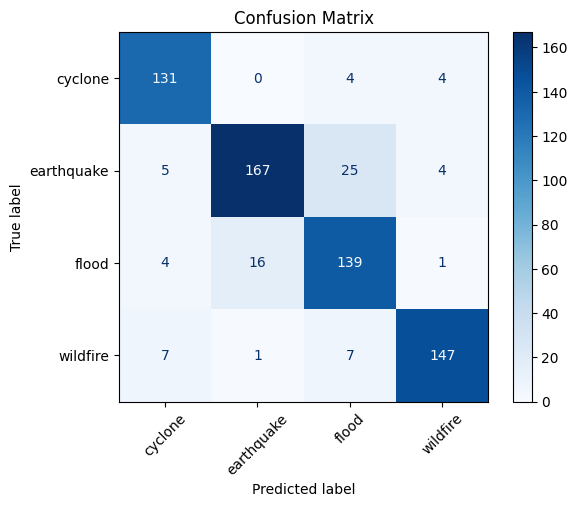

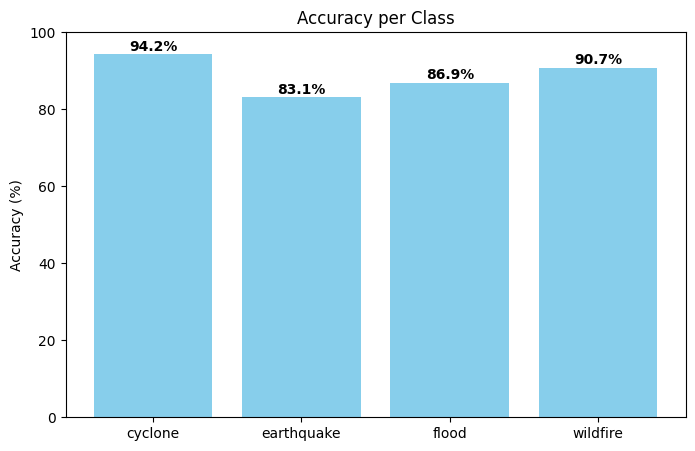

In [111]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Modeli evaluation moduna al
model.eval()

all_preds = []
all_labels = []

# Test datasetinde tahmin
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).long()

        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix oluştur
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Sınıf başına doğruluk grafiği
class_correct = cm.diagonal()
class_total = cm.sum(axis=1)
class_acc = 100 * class_correct / class_total

plt.figure(figsize=(8,5))
plt.bar(train_dataset.classes, class_acc, color='skyblue')
plt.ylabel("Accuracy (%)")
plt.ylim(0,100)
plt.title("Accuracy per Class")
for i, v in enumerate(class_acc):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')
plt.show()


Predicted class: wildfire


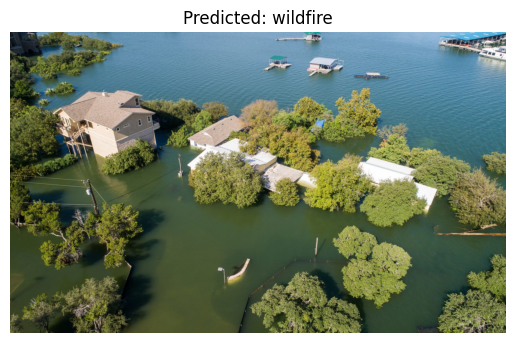

In [112]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt


img_path = "/content/drive/MyDrive/natural-disaster-image-dataset/natural_disaster_dataset/train/flood/12.jpg"


img = Image.open(img_path).convert("RGB")


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


input_tensor = transform(img).unsqueeze(0).to(device)


model.eval()


with torch.no_grad():
    outputs = model(input_tensor)
    predicted_class = torch.argmax(outputs, dim=1).item()


class_names = train_dataset.classes


print(f"Predicted class: {class_names[predicted_class]}")

plt.imshow(img)
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.axis("off")
plt.show()
